In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/semeion.data", delimiter=r"\s+",
                 header=None)

X = pd.DataFrame(df)
data = X.astype(int)

required_array = np.array(data.values)
required_array.resize(32,32)
print(required_array)


#Y = data[256:265] # classes

#Y = data[:,264]
#X = data[:, :255] # values


#print(Y)
#print(data)
X=data.iloc[:,0:266]
y=data.iloc[:,255:265] 

print(X)
print(y)





Instructions for updating:
non-resource variables are not supported in the long term
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
      0    1    2    3    4    5    6    ...  259  260  261  262  263  264  265
0       0    0    0    0    0    0    1  ...    0    0    0    0    0    0    0
1       0    0    0    0    0    1    1  ...    0    0    0    0    0    0    0
2       0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
3       0    0    0    0    0    0    1  ...    0    0    0    0    0    0    0
4       0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1588    0    0    0    1    1    1    1  ...    0    0    0    0    0    0    1
1589    0    0    0    1    1    1    1  ...    0    0    0    0    0    0    1
1590    0    0    1    1    1    1    1  ...    0    0    0    0    0    0 

24.36618974700002


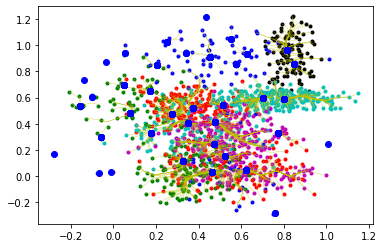

16.98145807100002


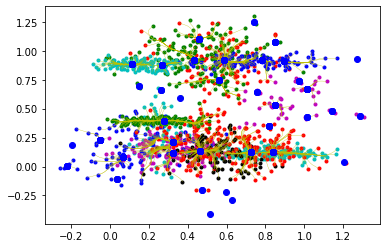

29.535072472999957


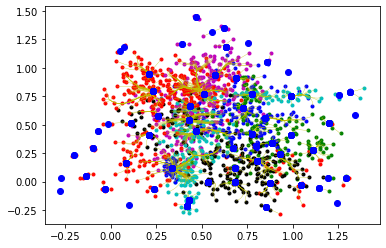

32.61511227


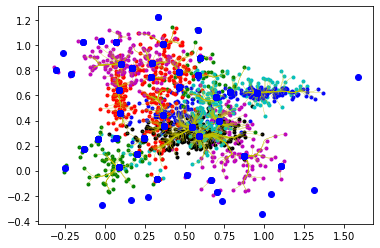

55.94336970299997


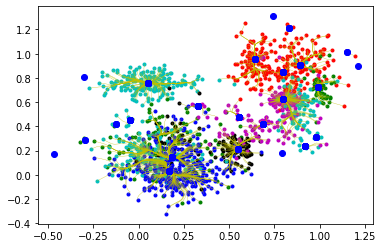

27.65184806100001


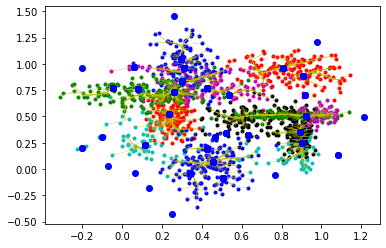

68.13931513


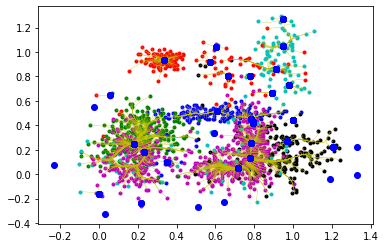

17.903082198999982


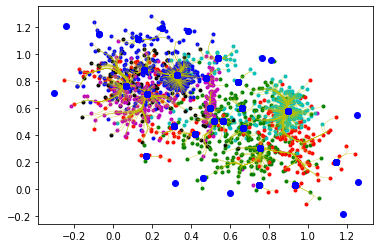

22.827837596999984


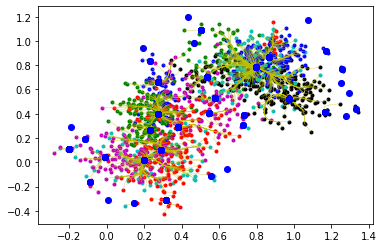

26.789697931999967


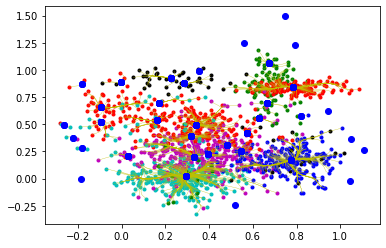

28.108569663000026


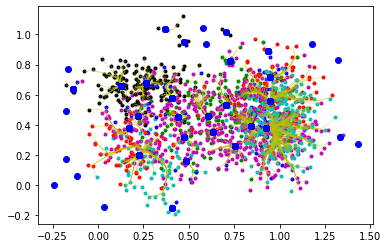

In [15]:
n_samples=required_array

n_centroids = n_samples # number of centroids
n_updates = -1 # 50 # number of updates
cluster = n_gaussians
for i in range(5,16):
    n_gaussians = i # 'true' number of clusters

    window_radius = .05
    dim = 2
    input_X = tf.placeholder(tf.float32, [None, dim])
    init_C = tf.placeholder(tf.float32, [None, dim])



    colors = ['r', 'c', 'm', 'g', 'k','b'] * 100


    def create_data(n_points, n_components):
      coefs = np.random.rand(n_components)
      coefs = coefs / np.sum(coefs)

      # create mean and cov
      mean = np.random.rand(n_components, dim)
      var = np.random.rand(n_components, dim, dim)

      for i in range(n_components):
          var[i, :, :] = np.diag(np.random.rand(dim)) / 30

      # sampling
      ids = np.random.choice(list(range(n_components)), size=n_points, replace=True, p=coefs)
      points = []
      for i in range(n_components):
          n = np.sum((ids == i).astype(np.int32))
          points.append(np.random.multivariate_normal(mean=mean[i, :], cov=var[i, :, :], size=n))

      return points


      def mean_shift(n_updates=-1):
          X1 = tf.expand_dims(tf.transpose(input_X), 0)
          X2 = tf.expand_dims(input_X, 0)
          C = init_C

          sbs_C = tf.TensorArray(dtype=tf.float32, size=10000, infer_shape=False)
          sbs_C = sbs_C.write(0, init_C)

      def _mean_shift_step(C):
            C = tf.expand_dims(C, 2)
            Y = tf.reduce_sum(tf.pow((C - X1) / window_radius, 2), axis=1)
            gY = tf.exp(-Y)
            num = tf.reduce_sum(tf.expand_dims(gY, 2) * X2, axis=1)
            denom = tf.reduce_sum(gY, axis=1, keep_dims=True)
            C = num / denom
            return C

      if n_updates > 0:
          for i in range(n_updates):
              C = _mean_shift_step(C)
              sbs_C = sbs_C.write(i + 1, C)
      else:
          def _mean_shift(i, C, sbs_C, max_diff):
              new_C = _mean_shift_step(C)
              max_diff = tf.reshape(tf.reduce_max(tf.sqrt(tf.reduce_sum(tf.pow(new_C - C, 2), axis=1))), [])
              sbs_C = sbs_C.write(i + 1, new_C)
              return i + 1, new_C, sbs_C, max_diff

          def _cond(i, C, sbs_C, max_diff):
              return max_diff > 1e-5

          n_updates, C, sbs_C, _ = tf.while_loop(cond=_cond,
                                       body=_mean_shift,
                                       loop_vars=(tf.constant(0), C, sbs_C, tf.constant(1e10)))

          n_updates = tf.Print(n_updates, [n_updates])


          return C, sbs_C.gather(tf.range(n_updates + 1))


      def plot(X, C, sbs_C):
        for i, ps in enumerate(X):
          plt.plot(ps[:, 0], ps[:, 1], colors[i] + '.')

        for i in range(sbs_C.shape[1]):
          plt.plot(sbs_C[:, i, 0], sbs_C[:, i, 1], 'y', linewidth=0.3)

        plt.plot(C[:, 0], C[:, 1], 'bo')

        plt.show()


    if __name__ == "__main__":
        X = create_data(n_samples, cluster)
        stacked_X = np.vstack(X)
        # C = stacked_X[np.random.randint(stacked_X.shape[0], size=n_centroids), :]
        C = stacked_X
        ms_C, sbs_ms_C = mean_shift(n_updates)

        sess = tf.Session()
        t = time.process_time()
        C, sbs_C = sess.run([ms_C, sbs_ms_C], feed_dict={input_X: stacked_X, init_C: C})
        print(time.process_time() - t)

        sbs_C = np.reshape(sbs_C, [-1, C.shape[0], C.shape[1]])

        plot(X, C, sbs_C)
